<a href="https://colab.research.google.com/github/manas-nambiar/EmoToneDetect/blob/main/EmoToneDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the description for the Ryerson Audio-Visual Database of Emotional
Speech and Song (RAVDESS) as stated on
https://zenodo.org/record/1188976#.ZGrz4ezMJhE:

About Dataset
Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
Song audio-only files (16bit, 48kHz .wav) from the RAVDESS. Full dataset of
speech and song, audio and video (24.8 GB) available from Zenodo. Construction
and perceptual validation of the RAVDESS is described in our Open Access paper
in PLoS ONE.

Check out our Kaggle Speech emotion dataset.

Files

This portion of the RAVDESS contains 1012 files: 44 trials per actor x 23
actors = 1012. The RAVDESS contains 24 professional actors (12 female, 12 male),
vocalizing two lexically-matched statements in a neutral North American accent.
Song emotions includes calm, happy, sad, angry, and fearful expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

File naming convention

Each of the 1012 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-02-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-02-06-01-02-01-12.wav

Audio-only (03)
Song (02)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

# Mounting the drive in order to access our files

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Installing all the libraries required for this project

In [ ]:
!pip install librosa
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install scikit-optimize
!pip install skopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt


# Import all the libraries required for this project

In [ ]:
import librosa
import numpy as np
import pandas as pd
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from sklearn.svm import SVC
%matplotlib inline

# Load a sample file and display it as a waveplot

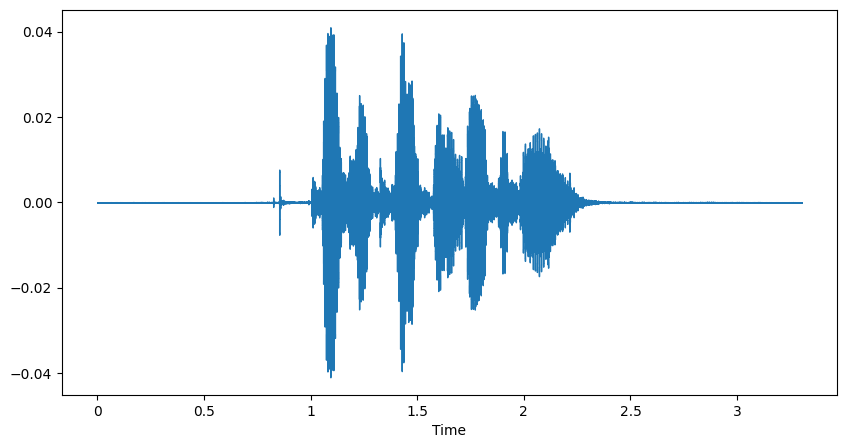

In [ ]:
data, sampling_rate = librosa.load('/content/drive/My Drive/RAVDESS/03-01-01-01-01-01-01.wav')
plt.figure(figsize=(10, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
dataset_path = "/content/drive/My Drive/RAVDESS/"
labels = []
X = np.empty((0, 1 + 20 + 1 + 1 + 1 + 1))

# Load all the files in

In [ ]:
start_time = time.time()

for file in os.listdir(dataset_path):
    if file.endswith('.wav'):
        file_info = file.split("-")
        modality = file_info[0]
        vocal_channel = file_info[1]
        emotion = file_info[2]
        emotional_intensity = file_info[3]
        statement = file_info[4]
        repetition = file_info[5]
        actor = file_info[6].split(".")[0]
        audio_file = os.path.join(dataset_path, file)
        y, sr = librosa.load(audio_file, sr=None)
        chroma_stft = librosa.feature.chroma_stft(y = y, sr = sr).mean()
        mfcc = librosa.feature.mfcc(y = y, sr = sr).mean(axis = 1)
        spectral_centroid = librosa.feature.spectral_centroid(y = y, sr = sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y = y, sr = sr).mean()
        rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y = y).mean()
        features_array = np.array([chroma_stft, *mfcc, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate])
        X = np.vstack((X, features_array))
        labels.append({'modality': modality,
                       'vocal_channel': vocal_channel,
                       'emotion': emotion,
                       'emotional_intensity': emotional_intensity,
                       'statement': statement,
                       'repetition': repetition,
                       'actor': actor})

np.save('features.npy', X)
labels_df = pd.DataFrame(labels)
labels_df.to_csv('labels.csv', index=False)

print("Data loaded in %s seconds" % (time.time() - start_time))

--- Data loaded. Loading time: 348.4784393310547 seconds ---


In [ ]:
X = np.load('features.npy')
y = pd.read_csv('labels.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y['emotion'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

0.17119359970092773 seconds taken to prepare model

Accuracy: 74.33808553971487%
Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        34
           1       0.76      0.87      0.81        83
           2       0.74      0.72      0.73        76
           3       0.75      0.70      0.72        73
           4       0.89      0.79      0.84        72
           5       0.70      0.69      0.70        72
           6       0.72      0.70      0.71        40
           7       0.73      0.78      0.75        41

    accuracy                           0.74       491
   macro avg       0.73      0.73      0.73       491
weighted avg       0.75      0.74      0.74       491



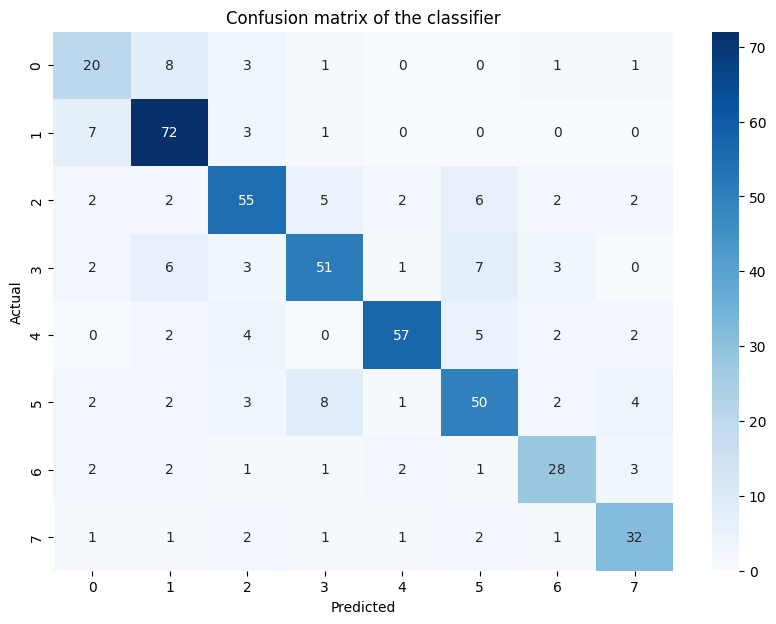

In [ ]:
# Scale the features
start_time = time.time()

svc = SVC()
svc = SVC(kernel='rbf', C=10, gamma='scale')
svc.fit(X_train, y_train)
print("%s seconds taken to prepare model\n" % (time.time() - start_time))

y_pred = svc.predict(X_test)

confusion = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


print("Accuracy: %s%%" % (accuracy*100))
print("Classification Report: \n", classification_rep)

plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix of the classifier')
plt.show()

In [ ]:
start_time = time.time()

# Define the hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Perform GridSearch for hyperparameter tuning
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("%s seconds taken to prepare model\n" % (time.time() - start_time))

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the tuned model on the test set
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Confusion Matrix: \n\n", confusion_mat)
print("Classification Report: \n", classification_rep)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
394.49080324172974 seconds taken to prepare model

Best Parameters:  {'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy:  0.7494908350305499
Confusion Matrix: 

 [[25  4  3  1  0  0  0  1]
 [ 6 73  2  2  0  0  0  0]
 [ 3  2 57  5  2  4  1  2]
 [ 3  7  1 53  0  6  2  1]
 [ 0  2  4  0 56  4  2  4]
 [ 0  3  3 11  2 49  2  2]
 [ 2  2  2  2  1  2 27  2]
 [ 2  0  3  2  2  4  0 28]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.74      0.67        34
           1       0.78      0.88      0.83        83
           2       0.76      0.75      0.75        76
           3       0.70      0.73      0.71        73
           4       0.89      0.78      0.83        72
           5       0.71      0.68      0.70        72
           6       0.79      0.68      0.73        40
           7       0.70      0.68      0.69        41

    accuracy                 

In [ ]:
# Train an SVM classifier
start_time = time.time()
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train, y_train)
print("%s seconds taken to prepare model\n" % (time.time() - start_time))
# Predict the labels for the test set
y_pred = svm.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:\n', confusion)
print('Classification report:\n', report)

0.1788642406463623 seconds taken to prepare model

Accuracy: 0.7433808553971487
Confusion matrix:
 [[20  8  3  1  0  0  1  1]
 [ 7 72  3  1  0  0  0  0]
 [ 2  2 55  5  2  6  2  2]
 [ 2  6  3 51  1  7  3  0]
 [ 0  2  4  0 57  5  2  2]
 [ 2  2  3  8  1 50  2  4]
 [ 2  2  1  1  2  1 28  3]
 [ 1  1  2  1  1  2  1 32]]
Classification report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.57        34
           1       0.76      0.87      0.81        83
           2       0.74      0.72      0.73        76
           3       0.75      0.70      0.72        73
           4       0.89      0.79      0.84        72
           5       0.70      0.69      0.70        72
           6       0.72      0.70      0.71        40
           7       0.73      0.78      0.75        41

    accuracy                           0.74       491
   macro avg       0.73      0.73      0.73       491
weighted avg       0.75      0.74      0.74       491

